In [49]:
from LightPipes import *
from torch import nn

import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import torch  as tc

In [50]:
def Lambda(M,N,sigma,delta):
  a = 1/(4*sigma**2) # [L]^-2
  b = 1/(2*delta**2) # [L]^-2
  c = 2*np.sqrt( a**2 + 2*a*b )
  L = ( np.pi/(a + b + c/2) )*( (a + b - c/2)/( a + b + c/2 ) )**( abs(M)/2 + N )
  return L

def data_GSM(n=2**6,dx= 20*um,sigma=.1*mm,delta=.1*mm,L=50,P=50,cutoff00=0.0015):
  Numero_de_Soma_Inc = 0
  for j in range(-L,L+1):
      for jj in range(P+1):
          cutoff  = Lambda(j,jj,sigma,delta)/Lambda(0,0,sigma,delta)
          if (cutoff >= cutoff00):
              Numero_de_Soma_Inc +=1

  #Parâmetros do feixe GSM
  x = np.arange(-n/2, n/2,1)*dx
  xx,yy = np.meshgrid(x,x)

  #Gerando os campos para a soma incoerente

  a = 1/(4*sigma**2) # [L]^-2
  b = 1/(2*delta**2) # [L]^-2
  c = 2*np.sqrt( a**2 + 2*a*b )
  w = np.sqrt( 2/c )
  weights_00 = Lambda(0,0,sigma,delta)

  Campos2 =  np.exp( 1j*np.zeros((n,n,Numero_de_Soma_Inc))) # Campo
  I_gsm   =  np.zeros((n,n)) # Intensidade
  weights_lista = np.zeros(Numero_de_Soma_Inc)
  modes_lista = []
  i = 0
  for jj in range(P+1):
      for j in range(-L,L+1):
          weights = Lambda(j,jj,sigma,delta)
          cutoff  = weights/weights_00
          if (cutoff >= cutoff00):
              r    = np.sqrt(xx**2+yy**2)
              C    = np.sqrt(2*math.factorial(jj)/(np.pi*math.factorial(jj+abs(j))))
              PL   = scipy.special.assoc_laguerre(2*r**2/w**2,jj,abs(j))
              Fase = np.exp(- 1j*j*np.arctan2(yy,xx) )

              LG   = (C*1/w)*(r*np.sqrt(2)/w)**abs(j)*PL*np.exp(-r**2/w**2)*Fase
              Campos2[:,:,i] = np.sqrt(weights)*LG

              I_gsm += abs( np.conjugate(np.sqrt(weights)*LG)*(np.sqrt(weights)*LG) ) # Intensidade de cada modo
              weights_lista[i] = weights
              modes_lista.append([jj,j])
              i += 1

  return Campos2,I_gsm,weights_lista,modes_lista

def data_GSM2(n=2**6,dx= 20*um,sigma=.1*mm,delta=.1*mm,l=5,m=5):
  #Parâmetros do feixe GSM
  x = np.arange(-n/2, n/2,1)*dx
  xx,yy = np.meshgrid(x,x)

  #Gerando os campos para a soma incoerente
  a = 1/(4*sigma**2)
  b = 1/(2*delta**2)
  c = np.sqrt( a**2 + 2*a*b )

  Campos =  np.exp( 1j*np.zeros((n,n,l*m))) # Campo
  modes_lista = []

  i = 0
  for N in range(l):
    for M in range(m):
      C1 = np.sqrt(2*c/np.pi)/np.sqrt(2**(M + N))
      C2 = 1/np.sqrt(math.factorial(M))
      C3 = 1/np.sqrt(math.factorial(N))
      HermiteN = scipy.special.hermite(N, monic=True)
      HermiteM = scipy.special.hermite(M, monic=True)

      HG = C1*C2*C3*HermiteN(xx*np.sqrt(2*c))*HermiteM(yy*np.sqrt(2*c))*np.exp(-c*(xx**2 + yy**2))
      Campos[:,:,i]  = HG
      modes_lista.append([N,M])
      i += 1
  return Campos,modes_lista

In [51]:
def CSD_normalizada(fields, dx,index):
    #n = fields.shape[0]  # Assuming n is the size of one dimension of S

    mu = tc.zeros_like(fields[:, :, 1])
    intMap = tc.sum(tc.abs(tc.conj(fields)*fields), 2)

    mu= tc.sum(tc.conj(fields)*fields, 2)/tc.sqrt(intMap*intMap[index[0], index[1]])
    img = tc.abs(mu)
    img = img / img.max()

    return img
# Construindo o modelo
class Autodiff_gsm(nn.Module):
    """
    Os modos devem ter shape = [n,n,Numero de modos] onde n é a dimensao da simulaçao.
    Os parametros gerados vão ter shape = [Numero de modos].

    A saida tem shape = [n,n], pois já somamos todos os numeros de modos.
    """
    def __init__(self,modos):
        super().__init__()
        self.modos_  = modos
        self.lambds_ =nn.Parameter(tc.rand(modos.shape[-1],dtype=tc.float64)*0.1)
    def forward(self):
        campo = self.modos_*self.lambds_ # Multiplicando os campos
        # campo = abs(tc.conj(campo)*campo) # Obtendo a intensidade(z=0)
        # campo = tc.sum(campo,dim=-1) # Somando todos as Intensidades
        # campo = campo/campo.max() # Normalizando
        #campo = tc.round( campo, decimals=15) # Diminuindo a precisão
        return campo

gerando os dados

In [52]:
sigma = .1*mm        # largura
n     = 2**6          # Dimensão
dx    = 20*um         # Tamanho do pixel
x = np.arange(-n/2, n/2,1)*dx
xx,yy = np.meshgrid(x,x)

I_gsm_tensor = np.exp(-(xx**2+yy**2)/(2*sigma**2) )
mu_gsm_tensor = np.exp(-(xx**2+yy**2)/(4*sigma**2) )

In [53]:
fields,indice_HG = data_GSM2(l=7,m=7)
fields2,W_gsm,weights_gsm,indice_gsm = data_GSM()

fields_tensor = tc.from_numpy(fields).to(dtype=tc.complex64)  # Convertendo os modos de LG para tensor
fields_tensor2 = tc.from_numpy(fields2).to(dtype=tc.complex64) 
I_gsm_tensor = tc.from_numpy(I_gsm_tensor).to(dtype=tc.float64) # Convertendo a CSD para tensor
mu_gsm_tensor = tc.from_numpy(mu_gsm_tensor).to(dtype=tc.float64) # Convertendo a CSD para tensor


n     = 2**6          # Dimensão
dx    = 20*um         # Tamanho do pixel
x = np.arange(-n/2, n/2,1)*dx
xx,yy = np.meshgrid(x,x)

ref = [0,0]
index = np.where((xx==ref[0])*(yy==ref[1])==True)
len(weights_gsm)

28

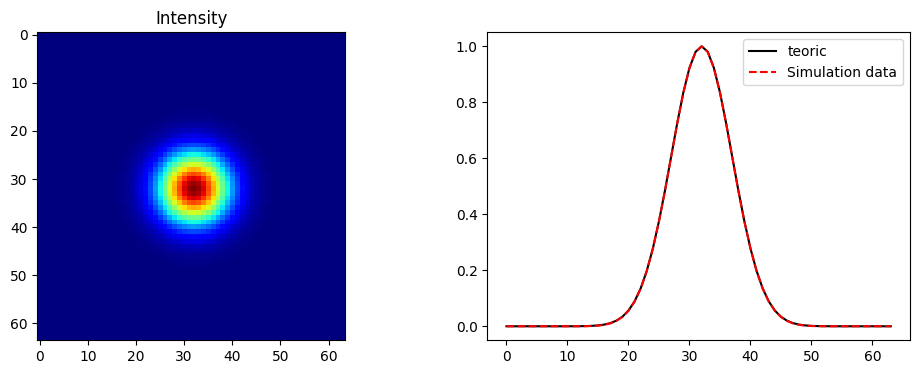

In [54]:
sigma = .1*mm        # largura
n     = 2**6          # Dimensão
dx    = 20*um         # Tamanho do pixel
x = np.arange(-n/2, n/2,1)*dx
xx,yy = np.meshgrid(x,x)

Intensidade = tc.sum(tc.abs(tc.conj(fields_tensor2)*fields_tensor2),2)
B = I_gsm_tensor[:,n//2].detach().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Plot the first figure in the first column
ax1.set_title("Intensity")
ax2.plot(B,"k-",label="teoric")
ax2.plot(Intensidade[:,n//2].detach().numpy(),"r--",label="Simulation data")
ax2.legend()

# Plot the second figure in the second column
ax1.imshow(Intensidade.detach().numpy(),cmap="jet")

plt.show()

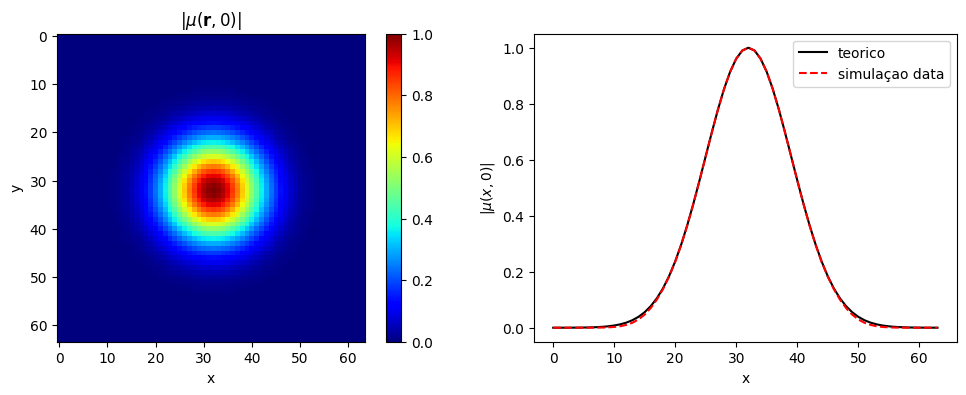

In [55]:
img = CSD_normalizada(fields_tensor2,dx,index).detach().numpy()
B = mu_gsm_tensor[:,n//2].detach().numpy()
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first image in the first subplot
axs[0].imshow(img, cmap="jet")
axs[0].set_title('|$\mu(\mathbf{r},0)$|')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Add a colorbar to the figure
fig.colorbar(axs[0].imshow(img, cmap="jet"), ax=axs[0])

# Plot the second graph in the second subplot
axs[1].plot(B,"k-", label='teorico')
axs[1].plot(img[:, n // 2],"r--", label='simulaçao data')
axs[1].set_xlabel('x')
axs[1].set_ylabel('|$\mu(x,0)$|')
axs[1].legend()
plt.show()

Criando o modelo

In [56]:
from torch.optim.lr_scheduler import StepLR

In [57]:
model = Autodiff_gsm(fields_tensor) # iniciando a instãncia.
loss_fn = nn.MSELoss() # Defininfo a loss fuction.
opt = tc.optim.Adam(params=model.parameters(),lr=0.01,betas= (0.9, 0.999))#Definindo o otimizador.

# Criando um scheduler para diminuir o learning rate a cada 'step_size' épocas
scheduler = StepLR(opt, step_size=200, gamma=0.9)
CutOFF = nn.Threshold(0.015, 0)

In [58]:
tc.abs(model.lambds_[0]- model.lambds_.max())

tensor(0.0926, dtype=torch.float64, grad_fn=<AbsBackward0>)

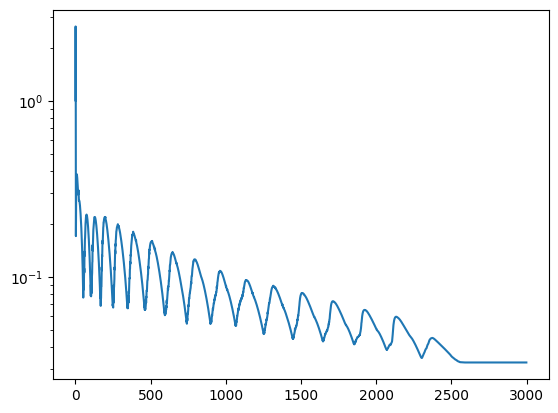

In [59]:
model = Autodiff_gsm(fields_tensor) # iniciando a instãncia.
loss_fn = nn.MSELoss() # Defininfo a loss fuction.
opt = tc.optim.Adam(params=model.parameters(),lr=0.1)#Definindo o otimizador.

# Criando um scheduler para diminuir o learning rate a cada 'step_size' épocas
scheduler = StepLR(opt, step_size=100, gamma=0.9)
CutOFF = nn.Threshold(0.0015, 0)


LOSSdata = []
for epoch in range(3000):
    phi = model()

    # Diferença entre a intensidade real e o predict.
    Intensidade = abs(tc.conj(phi)*phi) # Obtendo a intensidade(z=0)
    Intensidade = tc.sum(Intensidade,dim=-1) # Somando todos as Intensidades
    Intensidade = Intensidade/Intensidade.max() # Normalizando
    loss_data_I = loss_fn(Intensidade, I_gsm_tensor)

    # Diferença entre a csd normalizada real e o predict.
    csd = CSD_normalizada(phi,dx,index)
    loss_data_mu = loss_fn(csd, mu_gsm_tensor)

    # Termo de penalidade para garantir que os valores dos parâmetros sejam sempre positivos.
    penalidade_negativos = tc.relu(-model.lambds_).sum()

    loss_regulazation = tc.mean(tc.abs(model.lambds_))
    
    #loss_regulazation_cutoff = tc.mean(tc.abs(CutOFF(model.lambds_/model.lambds_[0])))

    loss_regulazation00 = tc.abs(model.lambds_[0]- model.lambds_.max())
    #loss = loss_data_I + loss_data_mu + penalidade_negativos + loss_regulazation_cutoff

    loss = loss_data_I + loss_data_mu + loss_regulazation  + penalidade_negativos + loss_regulazation00 

    opt.zero_grad()
    loss.backward()
    opt.step()
    LOSSdata.append(loss.detach().numpy())
    # Atualizando o scheduler a cada época
    scheduler.step()

plt.plot(LOSSdata)
plt.yscale("log")
plt.show()  

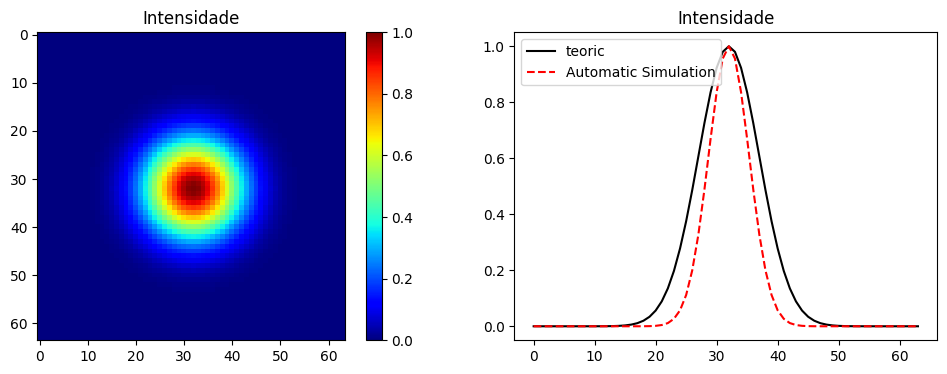

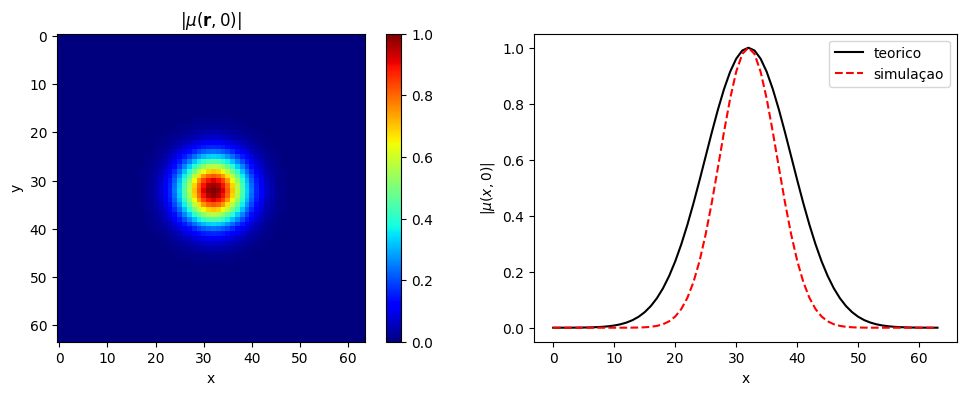

In [60]:
phi = model()
Intensidade = abs(tc.conj(phi)*phi) # Obtendo a intensidade(z=0)
Intensidade = tc.sum(Intensidade,dim=-1) # Somando todos as Intensidades
Intensidade = Intensidade/Intensidade.max() # Normalizando


sigma = .1*mm        # largura
n     = 2**6          # Dimensão
dx    = 20*um         # Tamanho do pixel
x = np.arange(-n/2, n/2,1)*dx
xx,yy = np.meshgrid(x,x)

ref = [0,0]
index = np.where((xx==ref[0])*(yy==ref[1])==True)

B = np.exp(-xx[n//2]**2/(2*sigma**2) )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
# Plot the second figure in the second column
ax1.imshow(Intensidade.detach().numpy(),cmap="jet")
ax1.set_title('Intensidade')
# Add a colorbar to the figure
fig.colorbar(ax1.imshow(img, cmap="jet"), ax=ax1)
# Plot the first figure in the first column
ax2.plot(B,"k-",label="teoric")
ax2.plot(Intensidade[:,n//2].detach().numpy(),"r--",label="Automatic Simulation")
ax2.legend()
ax2.set_title('Intensidade')
plt.show()



B = np.exp(-xx[n//2]**2/(4*sigma**2) )
# Chame a função para obter a imagem
img = CSD_normalizada(phi,dx,index).detach().numpy()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first image in the first subplot
axs[0].imshow(img, cmap="jet")
axs[0].set_title('|$\mu(\mathbf{r},0)$|')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Add a colorbar to the figure
fig.colorbar(axs[0].imshow(img, cmap="jet"), ax=axs[0])

# Plot the second graph in the second subplot
axs[1].plot(B,"k", label='teorico')
axs[1].plot(img[:, n // 2],"r--", label='simulaçao')
axs[1].set_xlabel('x')
axs[1].set_ylabel('|$\mu(x,0)$|')
axs[1].legend()

# Show the figure
plt.show()

In [61]:
def Lambda(M,N,sigma,delta):
    a = 1/(4*sigma**2) # [L]^-2
    b = 1/(2*delta**2) # [L]^-2
    c = 2*np.sqrt( a**2 + 2*a*b )
    L = ( np.pi/(a + b + c/2) )*( (a + b - c/2)/( a + b + c/2 ) )**( abs(M)/2 + N )
    return L

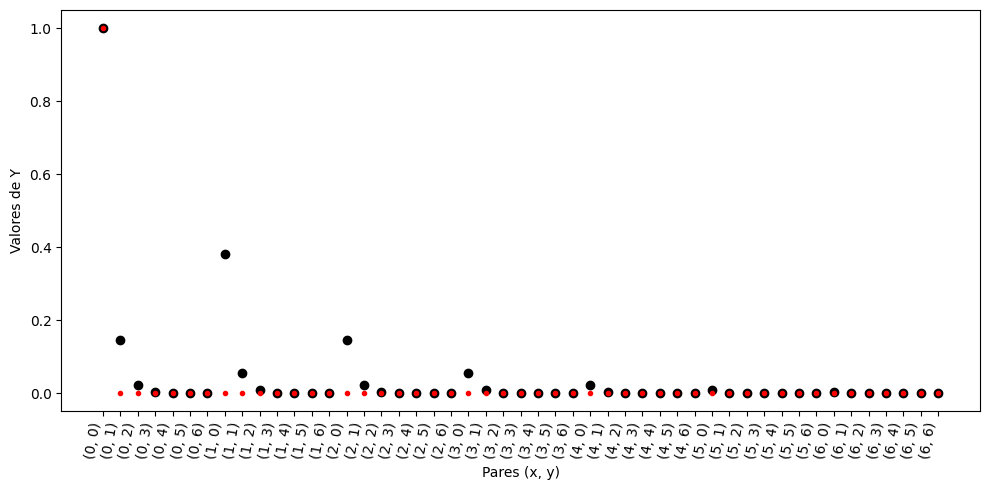

In [62]:
m = nn.Threshold(0.015, 0)
lambdas_norma = m(model.lambds_/model.lambds_.max()).detach().numpy()
lambdas_norma0 = model.lambds_.detach().numpy()

# Convertendo pares para strings para usar como rótulos
x_labels = [f'({x[0]}, {x[1]})' for x in indice_HG]

delta =sigma

top = [ Lambda(x[0],x[1],sigma,delta)/Lambda(0,0,sigma,delta)  for x in indice_HG ] 

# Criando o gráfico
plt.figure(figsize=(10, 5))  # Ajustando o tamanho da figura para melhor visualização
plt.plot(x_labels, top,"ko")  
plt.plot(x_labels, lambdas_norma,"r.")  


# Ajustando rótulos do eixo x para melhorar a visualização
plt.xticks(rotation=80, ha='right')  # Rotacionando os rótulos para melhor visualização
# Definindo rótulos dos eixos
plt.xlabel('Pares (x, y)')
plt.ylabel('Valores de Y')
# Mostrar o gráfico
plt.tight_layout()  # Ajusta automaticamente os parâmetros da subtrama
plt.show()

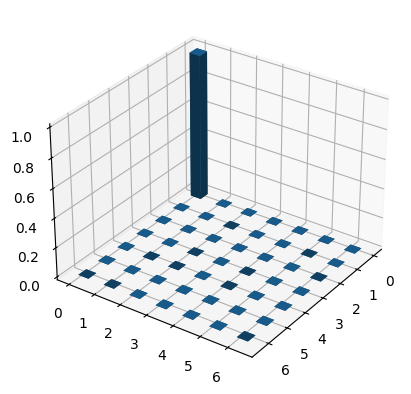

In [63]:
x = []
y = []
for i,j in indice_HG:
    x.append(j)
    y.append(i)
x, y = np.array(x), np.array(y)


fig = plt.figure( )
ax1 = fig.add_subplot( projection='3d')


top = m(model.lambds_/model.lambds_.max()).detach().numpy()
bottom = np.zeros_like(top)

ax1.bar3d(x, y, bottom, 0.4, 0.4, top)
# Invertendo o eixo x
#ax1.set_xlim(ax1.get_xlim()[::-1])

# Invertendo o eixo y
#ax1.set_ylim(ax1.get_ylim()[::-1])

# Definindo o ângulo de visualização
elev = 30  # Elevação em graus
azim = 35  # Azimute em graus
ax1.view_init(elev=elev, azim=azim)
plt.show()

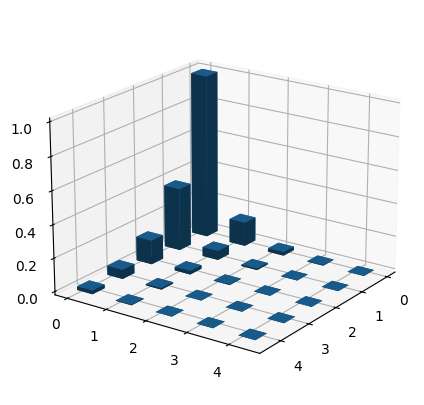

In [64]:
import matplotlib.colors as colors
import matplotlib.cm as cm

fig = plt.figure( figsize=(5,5))
ax1 = fig.add_subplot( projection='3d')
# fake data
_x = range(0,5)
_y = range(0,5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = Lambda(x,y,sigma,delta)/Lambda(0,0,sigma,delta)
bottom = np.zeros_like(top)

ax1.bar3d(x, y, bottom, 0.4, 0.4, top, shade=True, cmap=cm.plasma)
# Invertendo o eixo x
#ax1.set_xlim(ax1.get_xlim()[::-1])

# Invertendo o eixo y
#ax1.set_ylim(ax1.get_ylim()[::-1])

# Definindo o ângulo de visualização
elev = 20  # Elevação em graus
azim = 35  # Azimute em graus
ax1.view_init(elev=elev, azim=azim)

plt.show()
